## RTK + GG Visualization
#### April Novak

This notebook illustrates how to visualize a combined RTK (in-core) and GG (ex-core) geometry. This notebook is held on `orthanc`, but is launched through the Mounts, so my personal machine has to have the `casl2omni` branch checked out so that my machine knows about those updates. To do this, from `~/projects/Exnihilo`, do `git fetch; git checkout -t origin/casl2omni`. Then, build in the build directory on my personal machine (`~/Builds/Exnihilo`) by doing `make install`. Then, because this notebook is being launched from a Mount, the file path in the `ex-core.gg.xml` file that is to be read in must be edited so that the correct path (_through the Mount_) is read.


In [1]:
import sys

import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# path to Exnihilo-specific python modules on your machine. This is a path
# on a personal machine due to the mounting to orthanc.
sys.path.insert(0, '/Users/aprilnovak/Installs/python')

import exnihilotools.matplotlib as extools

extools.screen_style()
%matplotlib inline

In [2]:
# for plotting tallies
from omnibus.data import plot
from matplotlib.colors import Normalize, LogNorm

In [3]:
# This shows where this notebook is importing geometria from
import geometria
geometria.__file__

'/Users/aprilnovak/Installs/python/geometria.py'

In [4]:
# for plotting geometry
from geometria import GG_Geometry
from omnibus.raytrace.colors import ColorMap
from omnibus.raytrace.imager import Imager
from omnibus.raytrace.load import load_gg

In [5]:
xml_path = '/Users/aprilnovak/Mounts/orthanc/projects/nkq_analysis/vera-inputs/4x4-excore/'
# Because this is launched through the Mount, you have to manually edit the file path within 
# the XML file so that it is reading from the Mount.
filename = '4x4-excore-notebook.gg.xml'
comp_filename = '4x4-excore.shift_compositions-custom.h5'

model = load_gg(xml_path + filename)

In [6]:
# record description of the model
description = model.geometry.describe()

In [7]:
# Set parameters for the plots
tracer = 'cell'
color_map = 'CMRmap'

In [8]:
# try to make all the colors the same
from omnibus.formats.comp import load as load_comps
from omnibus.raytrace.colors import Composition

comps = load_comps(xml_path + comp_filename)
comps = [Composition(**d) for d in comps['compositions'].tolist()]

print(comps[0])


Loading HDF5 file...
Loading Compositions from HDF5 data at /Users/aprilnovak/Mounts/orthanc/projects/nkq_analysis/vera-inputs/4x4-excore/4x4-excore.shift_compositions-custom.h5
INFO: Loaded 'UNKNOWN': Compositions calculated on 2017JAN18 14:13
INFO: Data generated with Exnihilo version b'6.2 (r29396: #b538b683 on 2017JAN05) [DBC=7]', Scale version b'6.3 (r22322: #12f94e8b on 2017JAN10) [DBC=7]'
            ...finished loading HDF5 file


Composition(
 name        = b'0',
 matid       = 0,
 density     = 0.0,
 temperature = 9.9999999999999995e-08,
 zaid        = array([], dtype=uint32),
 wtfrac      = array([], dtype=float64),
 depletable  = False,
 fissionable = False,
)


/Users/aprilnovak/Installs/python/omnibus/data/dataset.py:146: RuntimeWarning: Extracting compound dataset manually because this version of h5py does not properly support aligned data types
  "data types", RuntimeWarning)


In [9]:
#tolist = comps.compositions.tolist()
#print(tolist[0])

In [10]:
colors = ColorMap.from_compositions(comps)

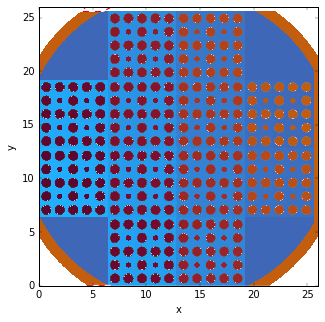

In [17]:
z = 0.5
x = 4*6.5
y = 4*6.5

# plot using a method where you can specify the lower left corner and the 
# upper right corner of the desired domain
imager = Imager(model.geometry, lower = (0.0, 0.0, z), upper = (x, y, z), \
                basis = (1, 0, 0), max_pixels=1200)
imager.set_colors(colors)
imager.check_errors = True
imager.plot(figsize=(5.0, 5.0));



{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x1138b7780>,
 'ax2': <matplotlib.axes._axes.Axes at 0x113834828>,
 'err': <matplotlib.contour.QuadContourSet at 0x11382f710>,
 'fig': <matplotlib.figure.Figure at 0x1140b8240>,
 'plot': <matplotlib.image.AxesImage at 0x11382f198>}

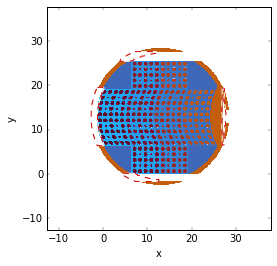

In [15]:
imager.scale(0.5)
imager.plot()

In [13]:
# plot a slice through the domain
imager = Imager.from_extents(model.geometry, z=0.5)
imager.trace = tracer
imager.plot();

RuntimeError: In universe 'reactor'->'core-array'->'pin-array': Could not find the volume connecting volume 1 (EXTERIOR) across surface 6 (outer.coz) at local point 5.28699 8.24043 0.5 along {1,0,0}: neighbors are {0, 1}, bounding volumes are {0, 1}
 ^^^ at {11.6869918353778,27.4404296875001,0.5} along {1,0,0}